In [ ]:
import os
import sys
import gc
import time
import pickle
import shutil
import tempfile
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(0)

import mxnet as mx
mx.random.seed(0)

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.model.predictor import Predictor
from gluonts.mx import Trainer
from gluonts.core.component import validated
from gluonts.mx.trainer.callback import Callback

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from train_models import *
from train_utils import *
from utils import *

import warnings
warnings.filterwarnings("ignore")

In [ ]:
class EarlyStoppingCallback(Callback):
    def __init__(self, patience: int):
        self.patience = patience
        self.best_loss = float('inf')
        self.wait_count = 0
        self.best_params_path = None
        self.temp_dir = None
        
    def __del__(self):
        if self.temp_dir is not None:
            shutil.rmtree(self.temp_dir, ignore_errors=True)
        
    def on_validation_epoch_end(
        self,
        epoch_no: int,
        epoch_loss: float,
        training_network: mx.gluon.HybridBlock,
        trainer: mx.gluon.Trainer,
    ) -> bool:
        if epoch_loss < self.best_loss:
            self.best_loss = epoch_loss
            self.wait_count = 0
            if self.temp_dir is None:
                self.temp_dir = tempfile.mkdtemp(prefix='early_stopping_')

            self.best_params_path = os.path.join(self.temp_dir, 'best_model.params')
            training_network.save_parameters(self.best_params_path)
        else:
            self.wait_count += 1
        if self.wait_count >= self.patience:
            print(f"Early stopping triggered")
            if self.best_params_path is not None:
                training_network.load_parameters(self.best_params_path)
                print("Restored best estimator")
            return False
        return True

class EarlyStoppingTrainer(Trainer):
    @validated()
    def __init__(self, patience: int, **kwargs):
        callbacks = kwargs.get('callbacks', [])
        callbacks.append(EarlyStoppingCallback(patience=patience))
        kwargs['callbacks'] = callbacks
        super().__init__(**kwargs)

In [ ]:
def get_optimal_num_batches(gpu_available, verbose=False):
    # memory
    memory_info = psutil.virtual_memory()
    total_memory = memory_info.total
    available_memory = memory_info.available

    # cpu
    cpu_usage = psutil.cpu_percent(interval=None)

    # gpu
    if gpu_available:
        try:
            gpus = GPUtil.getGPUs()
            if gpus:
                gpu_memory = sum(gpu.memoryTotal for gpu in gpus)
                gpu_memory_available = sum(gpu.memoryFree for gpu in gpus)
            else:
                gpu_memory = 0
                gpu_memory_available = 0
        except ImportError:
            gpu_memory = 0
            gpu_memory_available = 0
    else:
        gpu_memory = 0
        gpu_memory_available = 0

    # optimal
    memory_factor = available_memory / total_memory
    cpu_factor = (100 - cpu_usage) / 100
    gpu_factor = gpu_memory_available / max(gpu_memory, 1) if gpu_available else 1
    optimal_num_batches = int(200 * (0.5 * memory_factor + 0.3 * cpu_factor + 0.2 * gpu_factor))

    if verbose: print(f"Optimal num batches: {optimal_num_batches}")
    
    return max(1, optimal_num_batches)

def train_estimator(epochs, learning_rate, estimator_name):    
    save_dir = f'../result'
    os.makedirs(save_dir, exist_ok=True)
    
    for level_idx in range(1, 13):
        level_dir = os.path.join(save_dir, f'level {level_idx}')
        os.makedirs(level_dir, exist_ok=True)
        estimator_dir = os.path.join(level_dir, estimator_name)
        if any(existing_dir.startswith(estimator_name) for existing_dir in os.listdir(level_dir)):
            continue
        os.makedirs(estimator_dir, exist_ok=True)

        highlight_print(f"\n========== Level {level_idx} ==========")
        print(f"Loading dataset...", end=' ')
        dataset_start = time.time()
        if estimator_name == 'TFT':
            dataset_dir = '../dataset/tft'
        else:
            dataset_dir = '../dataset/else'
        with open(os.path.join(dataset_dir, f'dataset_level_{level_idx}.pkl'), 'rb') as f:
            dataset = pickle.load(f)
        print(f"{(time.time() - dataset_start)/60:.1f} minutes")

        estimator = create_estimator(
            level_idx=level_idx, 
            train_dataset=dataset['train'],
            estimator_name=estimator_name,
        )  

        estimator_start = time.time()
        print("Start training...")
        train_start = time.time()
        estimator.trainer = EarlyStoppingTrainer(
            epochs=epochs,
            learning_rate=learning_rate,
            num_batches_per_epoch=get_optimal_num_batches(mx.context.num_gpus()),
            patience=15,
        )
        predictor = estimator.train(
            training_data=dataset['train'],
            validation_data=dataset['valid']
        )
        predictor.serialize(Path(f"{level_dir}/{estimator_name}"))
        highlight_print(f"End training... {(time.time() - train_start)/60:.1f} minutes", color='green')

        print("Start predicting...")
        pred_start = time.time()
        test_forecasts_it, test_labels_it = make_evaluation_predictions(
            dataset=dataset['test'],
            predictor=predictor,
        )
        test_forecasts = list(test_forecasts_it)
        test_labels = list(test_labels_it)
        highlight_print(f"End predicting... {(time.time() - pred_start)/60:.1f} minutes", color='green')

        print("Start saving...")
        pred_save_start = time.time()
        with open(f"{level_dir}/{estimator_name}/test_labels.pkl", "wb") as f:
            pickle.dump(test_labels, f)
        with open(f"{level_dir}/{estimator_name}/test_forecasts.pkl", "wb") as f:
            pickle.dump(test_forecasts, f)
        highlight_print(f"End saving... {(time.time() - pred_save_start)/60:.1f} minutes", color='green')

        # print("Start plotting...")
        # plot_start = time.time()
        # for i in range(len(test_forecasts)):
        #     plt.figure(figsize=(12, 6))
        #     plt.plot(test_labels[i][-100:].to_timestamp(), label="Actual")
        #     plt.plot(pd.Series(test_forecasts[i].quantile(0.5), index=test_forecasts[i].start_date.to_timestamp() + pd.to_timedelta(range(len(test_forecasts[0].quantile(0.5))), unit='D')), label="Forecast")
        #     plt.title(f'{test_forecasts[i].item_id}')
        #     plt.xlabel('Date')
        #     plt.ylabel('Sales')
        #     plt.legend(loc="upper right")
        #     plt.savefig(os.path.join(estimator_dir, f'series_{i + 1}.png'))
        #     plt.close()
        # highlight_print(f"End plotting... {(time.time() - plot_start)/60:.1f} minutes", color='green')
            
        print("Start evaluating...")
        eval_start = time.time()
        evaluator = Evaluator(quantiles=(0.5,), ignore_invalid_values=True)
        test_metrics_all_id, test_metrics_per_id = evaluator(test_labels, test_forecasts)
        highlight_print(f"End evaluating... {(time.time() - eval_start)/60:.1f} minutes", color='green')

        print("Start saving...")
        eval_save_start = time.time()
        with open(f"{level_dir}/{estimator_name}/test_metrics_all_id.pkl", "wb") as f:
            pickle.dump(test_metrics_all_id, f)
        with open(f"{level_dir}/{estimator_name}/test_metrics_per_id.pkl", "wb") as f:
            pickle.dump(test_metrics_per_id, f)
        highlight_print(f"End saving... {(time.time() - eval_save_start)/60:.1f} minutes", color='green')

        highlight_print(f"\nTotal time: {(time.time() - estimator_start)/60:.1f} minutes", color='red')

        # rename estimator directory
        os.rename(estimator_dir, f"{estimator_dir}_{test_metrics_all_id['MSE']:.2f}")

        # reduce memory
        del estimator, predictor, test_forecasts, test_labels
        gc.collect()

In [ ]:
train_estimator(epochs=500, learning_rate=1e-3, estimator_name='TFT')

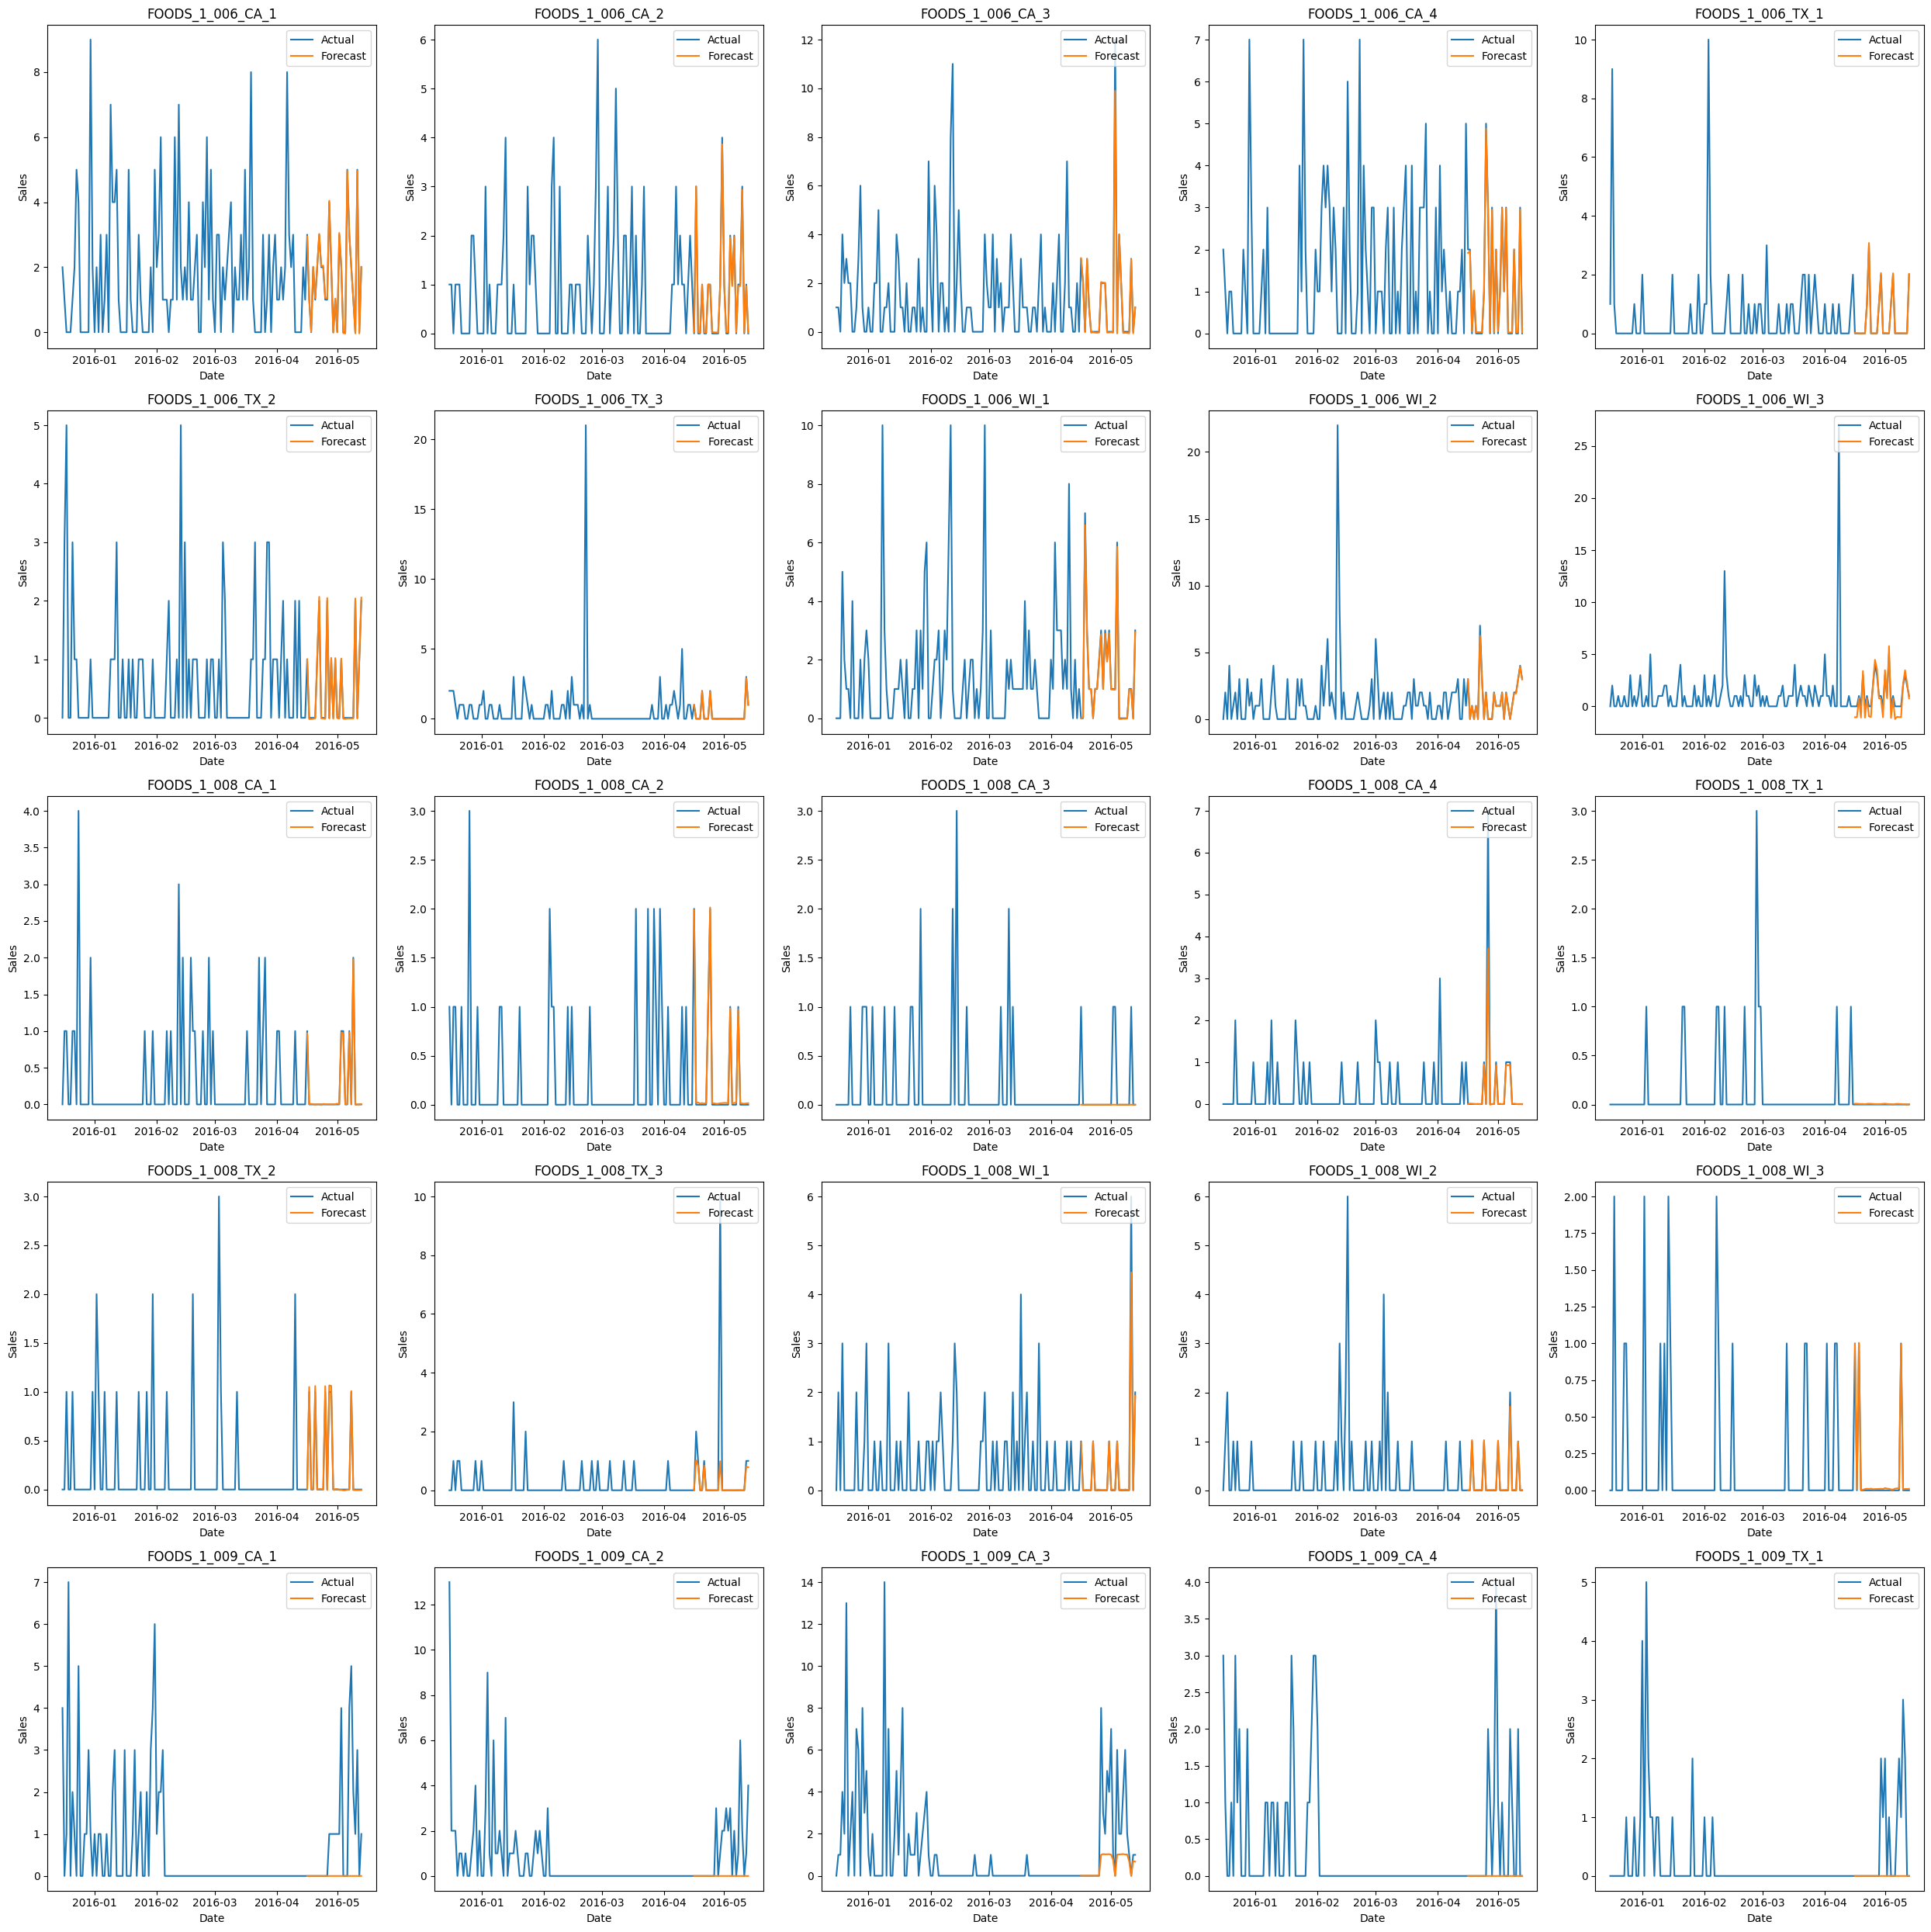

In [8]:
level_idx = 12
estimator = 'TFT'

ids = np.empty((0, ))
test_labels = np.empty((0, 28))
test_forecasts = np.empty((0, 28))

for level in range(level_idx, level_idx+1):
    level_dir = f"../result/level {level}"
    for model_dir in os.listdir(level_dir):
        if model_dir.startswith(estimator):
            model_path = os.path.join(level_dir, model_dir)
            if os.path.isdir(model_path):
                for root, dirs, files in os.walk(model_path):
                    for file in files:
                        if file.startswith('test_labels'):
                            with open(os.path.join(root, file), 'rb') as pickle_file:
                                test_labels = pd.read_pickle(pickle_file)
                        if file.startswith('test_forecasts'):
                            with open(os.path.join(root, file), 'rb') as pickle_file:
                                test_forecasts = pd.read_pickle(pickle_file)
    
    page = 2
    graphs_per_page = 25

    start_idx = page * graphs_per_page
    end_idx = start_idx + graphs_per_page

    num_plots = min(len(test_labels[start_idx:end_idx]), graphs_per_page)
    cols = 5
    rows = (num_plots + cols - 1) // cols 
    fig, axes = plt.subplots(rows, cols, figsize=(25, 5 * rows))

    for i in range(num_plots):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        ax.plot(test_labels[start_idx + i][-150:].to_timestamp(), label="Actual")
        ax.plot(pd.Series(test_forecasts[start_idx + i].quantile(0.5), index=test_forecasts[start_idx + i].start_date.to_timestamp() + pd.to_timedelta(range(len(test_forecasts[0].quantile(0.5))), unit='D')), label="Forecast")
        ax.set_title(f'{test_forecasts[start_idx + i].item_id}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        ax.legend(loc="upper right")

    for j in range(num_plots, rows * cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()
    plt.close()